In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torch
import numpy as np

from src.clusters import HierarchicalCluster
from src import (
  hierarchical_kmeans_gpu as hkmg,
  hierarchical_sampling as hs
)
from matplotlib import pyplot as plt
import pandas as pd
from cuml.manifold.umap import UMAP
import altair as alt
import base64
import io
from PIL import Image


from matplotlib.colors import LogNorm
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from io import BytesIO
from reportlab.lib.utils import ImageReader
from matplotlib.patches import Rectangle



In [2]:
features = np.load("/home/tcecconello/radioimgs/radio-data-curation-ssl/features/features.npy")
info = pd.read_json("/home/tcecconello/radioimgs/radio-data-curation-ssl/LoTSS/cutouts/info.json", orient="index")
info.head()

,file_path,source_type,survey,mosaic_name,position,size
0,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 3968]",256
1,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4096]",256
2,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4224]",256
3,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4352]",256
4,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4480]",256


In [3]:
cl = HierarchicalCluster.from_file("/home/tcecconello/radioimgs/radio-data-curation-ssl/data/try_1")
sampled_indices = hs.hierarchical_sampling(cl, target_size=200000)

Hierarchical sampling from clusters: 100%|██████████| 3000/3000 [00:01<00:00, 1691.92it/s]


In [11]:
np.max(sampled_indices)

3108220

In [5]:
print("Numerosità media dei cluster per livello \n Livello 1:{} \n Livello 2:{} \n Livello 3:{}".format(np.mean(cl.clusters_size[1]), np.mean(cl.clusters_size[2]), np.mean(cl.clusters_size[3])))
print("Numerosità massima dei cluster per livello \n Livello 1:{} \n Livello 2:{} \n Livello 3:{}".format(np.max(cl.clusters_size[1]), np.max(cl.clusters_size[2]), np.max(cl.clusters_size[3])))


Numerosità media dei cluster per livello 
 Livello 1:15.54116 
 Livello 2:10.0 
 Livello 3:6.666666666666667
Numerosità massima dei cluster per livello 
 Livello 1:90334 
 Livello 2:301 
 Livello 3:183


In [20]:
# Esempio di come trovare un indice specifico nei cluster
def trova_cluster(clusters, indice_target):
    for i, cluster in enumerate(clusters):
        if indice_target in cluster:
            return i, cluster
    return None, None

print("Livello 1, cluster 3:{}".format(cl.clusters[1][3]))
print("Index primo elemento:{}".format(cl.clusters[1][3][0]))
print("Livello 2, cluster dell'index:{}".format(trova_cluster(cl.clusters[2], cl.clusters[1][3][0])))
print("Livello 3, cluster dell'index:{}".format(cl.clusters[1][3]))

Livello 1, cluster 3:[ 438553  667019  674846  680471  848525  911256 1042741 1296163 1368456
 1380103 1550319 1606348 1734405 1788617 1878237 1883679 1883998 1942550
 1948231 2026907 2264933 2290897 2310848 2429568 2577753 2590452 2718367
 2860441 2970142 3024922  525923  613927  642591 1473409 1880274 2172862
 2433541 2593194 2946473 1464707 2071381 2430957 2511766 2509742 3014807
 1076944 1571499 1760894]
Index primo elemento:438553
Livello 2, cluster dell'index:(None, None)
Livello 3, cluster dell'index:[ 438553  667019  674846  680471  848525  911256 1042741 1296163 1368456
 1380103 1550319 1606348 1734405 1788617 1878237 1883679 1883998 1942550
 1948231 2026907 2264933 2290897 2310848 2429568 2577753 2590452 2718367
 2860441 2970142 3024922  525923  613927  642591 1473409 1880274 2172862
 2433541 2593194 2946473 1464707 2071381 2430957 2511766 2509742 3014807
 1076944 1571499 1760894]


In [22]:
import numpy as np

# Esempio di come trovare un indice specifico nei cluster
def trova_cluster(clusters, indice_target):
    for i, cluster in enumerate(clusters):
        if indice_target in cluster:
            return i, cluster
    return None, None

# Esempio di utilizzo
# Supponiamo di avere questi cluster di esempio
clusters = np.array([
    np.array([1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9])
])

indice_da_trovare = 5
numero_cluster, cluster_trovato = trova_cluster(clusters, indice_da_trovare)

if numero_cluster is not None:
    print(f"L'indice {indice_da_trovare} è nel cluster {numero_cluster}")
    print(f"Cluster completo: {cluster_trovato}")
else:
    print(f"L'indice {indice_da_trovare} non è stato trovato in nessun cluster")

L'indice 5 è nel cluster 1
Cluster completo: [4 5 6]


In [23]:
clusters

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [24]:
cl.clusters[2]

array([array([196940, 193509, 185271, 161271, 137340, 131241, 142343, 127136,
              103640, 123218,  14012,  54589, 123284, 136273, 140801, 180210,
              119090,  57578, 173502, 171347, 123322,  38517,  61320,  75844,
              190248, 126822, 114638,  72010, 124578, 148594, 131872, 157966]),
       array([5953]), array([29952, 18194]), ...,
       array([  8697,  46796,  48475,  64592,  65689,  97765, 102712, 125347,
              128865, 135075, 135489, 139855, 147812, 156268, 157805, 160512,
              167920, 185798,  22730, 116956, 124450, 136951, 158922, 159905,
              165493, 187142, 194024,  94401,  96072, 167477, 176386, 193558,
               46651,  90026, 172410, 190180, 146287])                       ,
       array([23298]), array([19356])], dtype=object)

In [26]:
import numpy as np
from collections import defaultdict

# Versione più efficiente che crea prima un dizionario di mapping
def crea_indice_cluster():
    indice_to_cluster = defaultdict(int)
    for i, cluster in enumerate(clusters):
        for elemento in cluster:
            indice_to_cluster[elemento] = i
    return indice_to_cluster

# Creazione dell'indice
mapping = crea_indice_cluster()

# Ricerca molto più veloce
indice_da_trovare = 5
cluster_numero = mapping.get(indice_da_trovare)

if cluster_numero is not None:
    cluster_trovato = clusters[cluster_numero]
    print(f"L'indice {indice_da_trovare} è nel cluster {cluster_numero}")
    print(f"Dimensione del cluster: {len(cluster_trovato)}")
    print(f"Cluster completo: {cluster_trovato}")
else:
    print(f"L'indice {indice_da_trovare} non è stato trovato in nessun cluster")

L'indice 5 è nel cluster 1
Dimensione del cluster: 3
Cluster completo: [4 5 6]


In [51]:
def trova_cluster_dettagliato(clusters, indice_target):
    for i, cluster in enumerate(clusters):
        if indice_target in cluster:
            return {
                'numero_cluster': i,
                'cluster': cluster,
                'dimensione_cluster': len(cluster),
                'posizione_indice': np.where(cluster == indice_target)[0][0]
            }
    return None

# Utilizzo
print("Livello 1, cluster 3: {}".format(cl.flat_clusters[1][3]))
primo_elemento = cl.flat_clusters[1][3][0]
print("Index primo elemento: {}".format(primo_elemento))

risultato = trova_cluster_dettagliato(cl.flat_clusters[2], primo_elemento)
if risultato:
    print("Livello 2, cluster dell'index: Cluster {} (dimensione: {})".format(
        risultato['numero_cluster'],
        risultato['dimensione_cluster']
    ))
    print("Cluster completo: {}".format(risultato['cluster']))
else:
    print("Indice non trovato nel livello 2")

risultato = trova_cluster_dettagliato(cl.flat_clusters[3], primo_elemento)
if risultato:
    print("Livello 3, cluster dell'index: Cluster {} (dimensione: {})".format(
        risultato['numero_cluster'],
        risultato['dimensione_cluster']
    ))
    print("Cluster completo: {}".format(risultato['cluster']))
else:
    print("Indice non trovato nel livello 3")

Livello 1, cluster 3: [ 438553  667019  674846  680471  848525  911256 1042741 1296163 1368456
 1380103 1550319 1606348 1734405 1788617 1878237 1883679 1883998 1942550
 1948231 2026907 2264933 2290897 2310848 2429568 2577753 2590452 2718367
 2860441 2970142 3024922  525923  613927  642591 1473409 1880274 2172862
 2433541 2593194 2946473 1464707 2071381 2430957 2511766 2509742 3014807
 1076944 1571499 1760894]
Index primo elemento: 438553
Livello 2, cluster dell'index: Cluster 8844 (dimensione: 320314)
Cluster completo: [ 438553  667019  674846 ... 3014599 2521653  646776]
Livello 3, cluster dell'index: Cluster 339 (dimensione: 2431771)
Cluster completo: [ 805365 1529338 2355123 ... 1728214 2417382 2218776]


In [38]:
np.max(cl.clusters[2])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [19]:
max_idx = max(np.max(cluster) for cluster in cl.clusters[3] if len(cluster) > 0)
print(f"L'indice massimo è: {max_idx}")

L'indice massimo è: 19999


In [12]:
print(cl.clusters)

{1: array([array([1363044]), array([1541499]), array([1449213]), ...,
        array([774086]), array([2333395]),
        array([ 732367,  853387,   63058, 2831787, 2000628, 1151379, 2932010,
               1557841, 1313362])                                            ],
       dtype=object),
 2: array([array([196940, 193509, 185271, 161271, 137340, 131241, 142343, 127136,
               103640, 123218,  14012,  54589, 123284, 136273, 140801, 180210,
               119090,  57578, 173502, 171347, 123322,  38517,  61320,  75844,
               190248, 126822, 114638,  72010, 124578, 148594, 131872, 157966]),
        array([5953]), array([29952, 18194]), ...,
        array([  8697,  46796,  48475,  64592,  65689,  97765, 102712, 125347,
               128865, 135075, 135489, 139855, 147812, 156268, 157805, 160512,
               167920, 185798,  22730, 116956, 124450, 136951, 158922, 159905,
               165493, 187142, 194024,  94401,  96072, 167477, 176386, 193558,
                466

In [13]:
print(cl.flat_clusters)

{1: array([array([1363044]), array([1541499]), array([1449213]), ...,
       array([774086]), array([2333395]),
       array([ 732367,  853387,   63058, 2831787, 2000628, 1151379, 2932010,
              1557841, 1313362])                                            ],
      dtype=object), 2: array([array([ 596386, 2101164, 1948367, 2560249, 2099188, 2290548, 2738726,
              3051303,  738721, 2863379,   89481,  386792, 1052247, 2157966,
              1837898, 2557987, 1296941, 2462196, 2305366, 2658030,  293253,
              1350404,  366374, 3052713,  278562,  549214, 2938562, 2066728,
              2513431,  587843, 3024987,  716538,  982653,  761611, 2332514]),
       array([1662392]), array([487474, 900757]), ...,
       array([2113938, 2279458,  998384, 2140702,  772527, 2500605,  154363,
              2509958, 2710897, 2533409, 1791877, 3025361,  864853, 1303091,
              1099949, 1237791,  228711, 2282112, 2280429,   18541, 1515722,
              1479718, 2903158, 263

In [21]:
def trace_item_across_levels(flat_clusters, clusters, item):
    """
    Traccia l'appartenenza di un elemento (item) nei cluster attraverso i livelli.

    Args:
        flat_clusters (dict): Cluster appiattiti per ogni livello.
        clusters (dict): Cluster non appiattiti per ogni livello.
        item (int): L'elemento da tracciare.

    Returns:
        dict: Un dizionario con i livelli come chiavi e i cluster di appartenenza come valori.
    """
    trace = {}  # Per tracciare il cluster di appartenenza a ciascun livello

    # Livello 1: Trova direttamente l'elemento
    for i, cluster in enumerate(flat_clusters[1]):
        if item in cluster:
            trace[1] = i  # Salva l'indice del cluster di livello 1
            break
    else:
        raise ValueError(f"Item {item} non trovato in livello 1")

    # Livelli successivi: Risali i livelli usando `clusters`
    current_cluster_index = trace[1]
    for level in range(2, len(flat_clusters) + 1):
        for i, cluster in enumerate(clusters[level]):
            if current_cluster_index in cluster:
                trace[level] = i  # Salva l'indice del cluster corrente
                current_cluster_index = i  # Aggiorna per il livello successivo
                break
        else:
            raise ValueError(f"Item {item} non trovato in livello {level}")

    return trace


In [22]:
item = 596386  # Elemento da tracciare
trace = trace_item_across_levels(cl.flat_clusters, cl.clusters, item)

# Stampa i risultati
for level, cluster_index in trace.items():
    print(f"Livello {level}: Cluster {cluster_index}")

Livello 1: Cluster 196940
Livello 2: Cluster 0
Livello 3: Cluster 2387


In [4]:
def get_item_clusters(flat_clusters, clusters, item):
    """
    Traccia l'appartenenza di un elemento (`item`) attraverso i livelli
    e restituisce gli indici e gli elementi dei cluster.

    Args:
        flat_clusters (dict): Cluster appiattiti per ogni livello.
        clusters (dict): Cluster non appiattiti per ogni livello.
        item (int): L'elemento da tracciare.

    Returns:
        dict: Dizionario con i livelli come chiavi e tuple (indice_cluster, elementi_cluster).
    """
    result = {}  # Per memorizzare indici e cluster di ciascun livello

    # Livello 1: Trova direttamente l'elemento
    for i, cluster in enumerate(flat_clusters[1]):
        if item in cluster:
            result[1] = (i, cluster)  # Salva indice e cluster
            break
    else:
        raise ValueError(f"Item {item} non trovato in livello 1")

    # Livelli successivi: Risali i livelli e raccogli cluster
    current_cluster_index = result[1][0]  # Indice del cluster a livello 1
    for level in range(2, len(flat_clusters) + 1):
        for i, cluster in enumerate(clusters[level]):
            if current_cluster_index in cluster:
                # Salva indice e cluster appiattito
                result[level] = (i, flat_clusters[level][i])
                current_cluster_index = i  # Aggiorna per il livello successivo
                break
        else:
            raise ValueError(f"Item {item} non trovato in livello {level}")

    return result


Livello 1:
  Indice del cluster: 5023
  Elementi del cluster: [2005117]
Livello 2:
  Indice del cluster: 4740
  Elementi del cluster: [2005117]
Livello 3:
  Indice del cluster: 0
  Elementi del cluster: [ 188046 2806259 2005117]


In [5]:
def plot_clusters(df, clusters_info, sampled_indices, n_cols=5, max_images=25):
    """
    Visualizza fino a un massimo di `max_images` immagini per cluster con bordi colorati.

    Args:
        df (pd.DataFrame): DataFrame contenente i path delle immagini (colonna "file_path").
        clusters_info (dict): Dizionario con i cluster di ciascun livello.
                              Formato: {livello: (indice_cluster, elementi_cluster)}.
        sampled_indices (list): Lista di indici con bordo verde (gli altri avranno bordo rosso).
        n_cols (int): Numero di colonne nel plot.
        max_images (int): Numero massimo di immagini da visualizzare per livello.
    """
    for level, (cluster_index, cluster_elements) in clusters_info.items():
        print(f"Plotting cluster {cluster_index} at level {level} with {len(cluster_elements)} images...")

        # Limita il numero di immagini da visualizzare
        cluster_elements = cluster_elements[:max_images]
        n_images = len(cluster_elements)
        n_rows = (n_images + n_cols - 1) // n_cols  # Calcola il numero di righe necessarie

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
        axs = axs.flatten()  # Per iterare facilmente sugli assi

        for i, ax in enumerate(axs):
            if i < n_images:
                image_index = cluster_elements[i]

                # Ottieni il file_path
                file_path = df.loc[image_index, "file_path"]
                if not os.path.exists(file_path):
                    print(f"File non trovato: {file_path}")
                    ax.axis('off')
                    continue

                # Carica l'immagine come array numpy
                image = np.load(file_path)
                image = np.log1p(image * 200)

                # Visualizza l'immagine
                ax.imshow(image, cmap='gray')
                ax.axis('off')

                # Aggiungi il bordo colorato
                border_color = "#80ef80" if image_index in sampled_indices else "red"
                rect = Rectangle((0, 0), image.shape[1], image.shape[0],
                                 linewidth=5, edgecolor=border_color, facecolor='none')
                ax.add_patch(rect)
            else:
                # Disattiva gli assi vuoti
                ax.axis('off')

        plt.suptitle(f"Cluster {cluster_index} - Livello {level}", fontsize=16)
        plt.tight_layout()
        plt.show()


In [7]:
item = sampled_indices[189999]  # Elemento da tracciare
clusters_info = get_item_clusters(cl.flat_clusters, cl.clusters, item)

# Visualizza gli indici e gli elementi dei cluster
for level, (cluster_index, cluster_elements) in clusters_info.items():
    print(f"Livello {level}:")
    print(f"  Indice del cluster: {cluster_index}")
    print(f"  Elementi del cluster: {cluster_elements}")


Livello 1:
  Indice del cluster: 80104
  Elementi del cluster: [68324]
Livello 2:
  Indice del cluster: 17935
  Elementi del cluster: [1038937 2524682 2050019 2099498  512202 1379705  575802  755706 1132502
 2814555   68324 1658300 2422237 1590261  577647 1291126 2099778 1441869
 1942994 1441711  181855 2625145 1557142  239986 1465677 2525934 2221198
 1439091  546205 2290146   15079 1799399  442380 1243210  575858  539865
 1759633 2445093 1417685  549698 1845101  958978  811166 1455180 1848136
 2361221 3033178 2521282  612105  892358 1302776 1926855 2658634 1844789
 2705544 1450931 2739366  342257  755645 2195846 1799337 2158145   68417
 2687009  643478 2497173 3002568 1549121 2850173  356562 1569487 1419064
 1934443  224731 1842934 2859598  926945 1160355 1944547 2290524 2496219
 1366630 2224800 1592176 2050015  206787  187183 1571199 1181314  185243
 1042358 1174420 2051061 1476881]
Livello 3:
  Indice del cluster: 2697
  Elementi del cluster: [2874626 2207785 1575330 ... 1311503 250

Livello 1:
  Indice del cluster: 80104
  Elementi del cluster: [68324]
Livello 2:
  Indice del cluster: 17935
  Elementi del cluster: [1038937 2524682 2050019 2099498  512202 1379705  575802  755706 1132502
 2814555   68324 1658300 2422237 1590261  577647 1291126 2099778 1441869
 1942994 1441711  181855 2625145 1557142  239986 1465677 2525934 2221198
 1439091  546205 2290146   15079 1799399  442380 1243210  575858  539865
 1759633 2445093 1417685  549698 1845101  958978  811166 1455180 1848136
 2361221 3033178 2521282  612105  892358 1302776 1926855 2658634 1844789
 2705544 1450931 2739366  342257  755645 2195846 1799337 2158145   68417
 2687009  643478 2497173 3002568 1549121 2850173  356562 1569487 1419064
 1934443  224731 1842934 2859598  926945 1160355 1944547 2290524 2496219
 1366630 2224800 1592176 2050015  206787  187183 1571199 1181314  185243
 1042358 1174420 2051061 1476881]
Livello 3:
  Indice del cluster: 2697
  Elementi del cluster: [2874626 2207785 1575330 ... 1311503 250

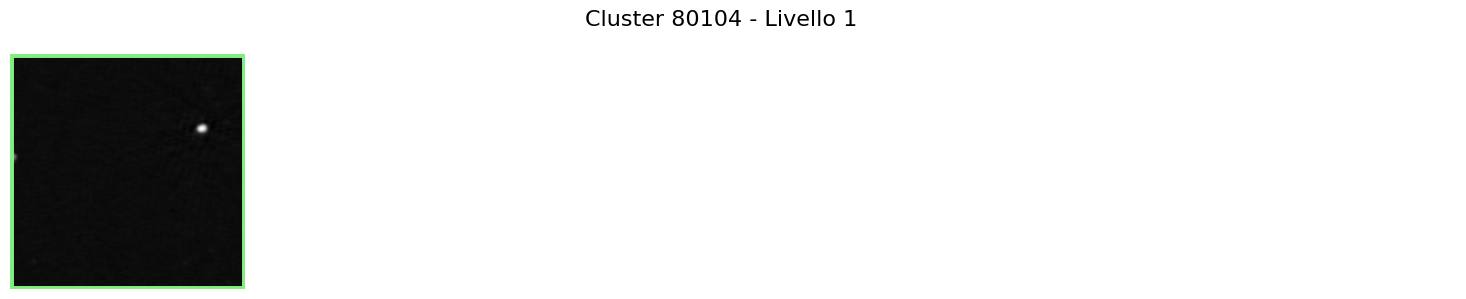

Plotting cluster 17935 at level 2 with 94 images...


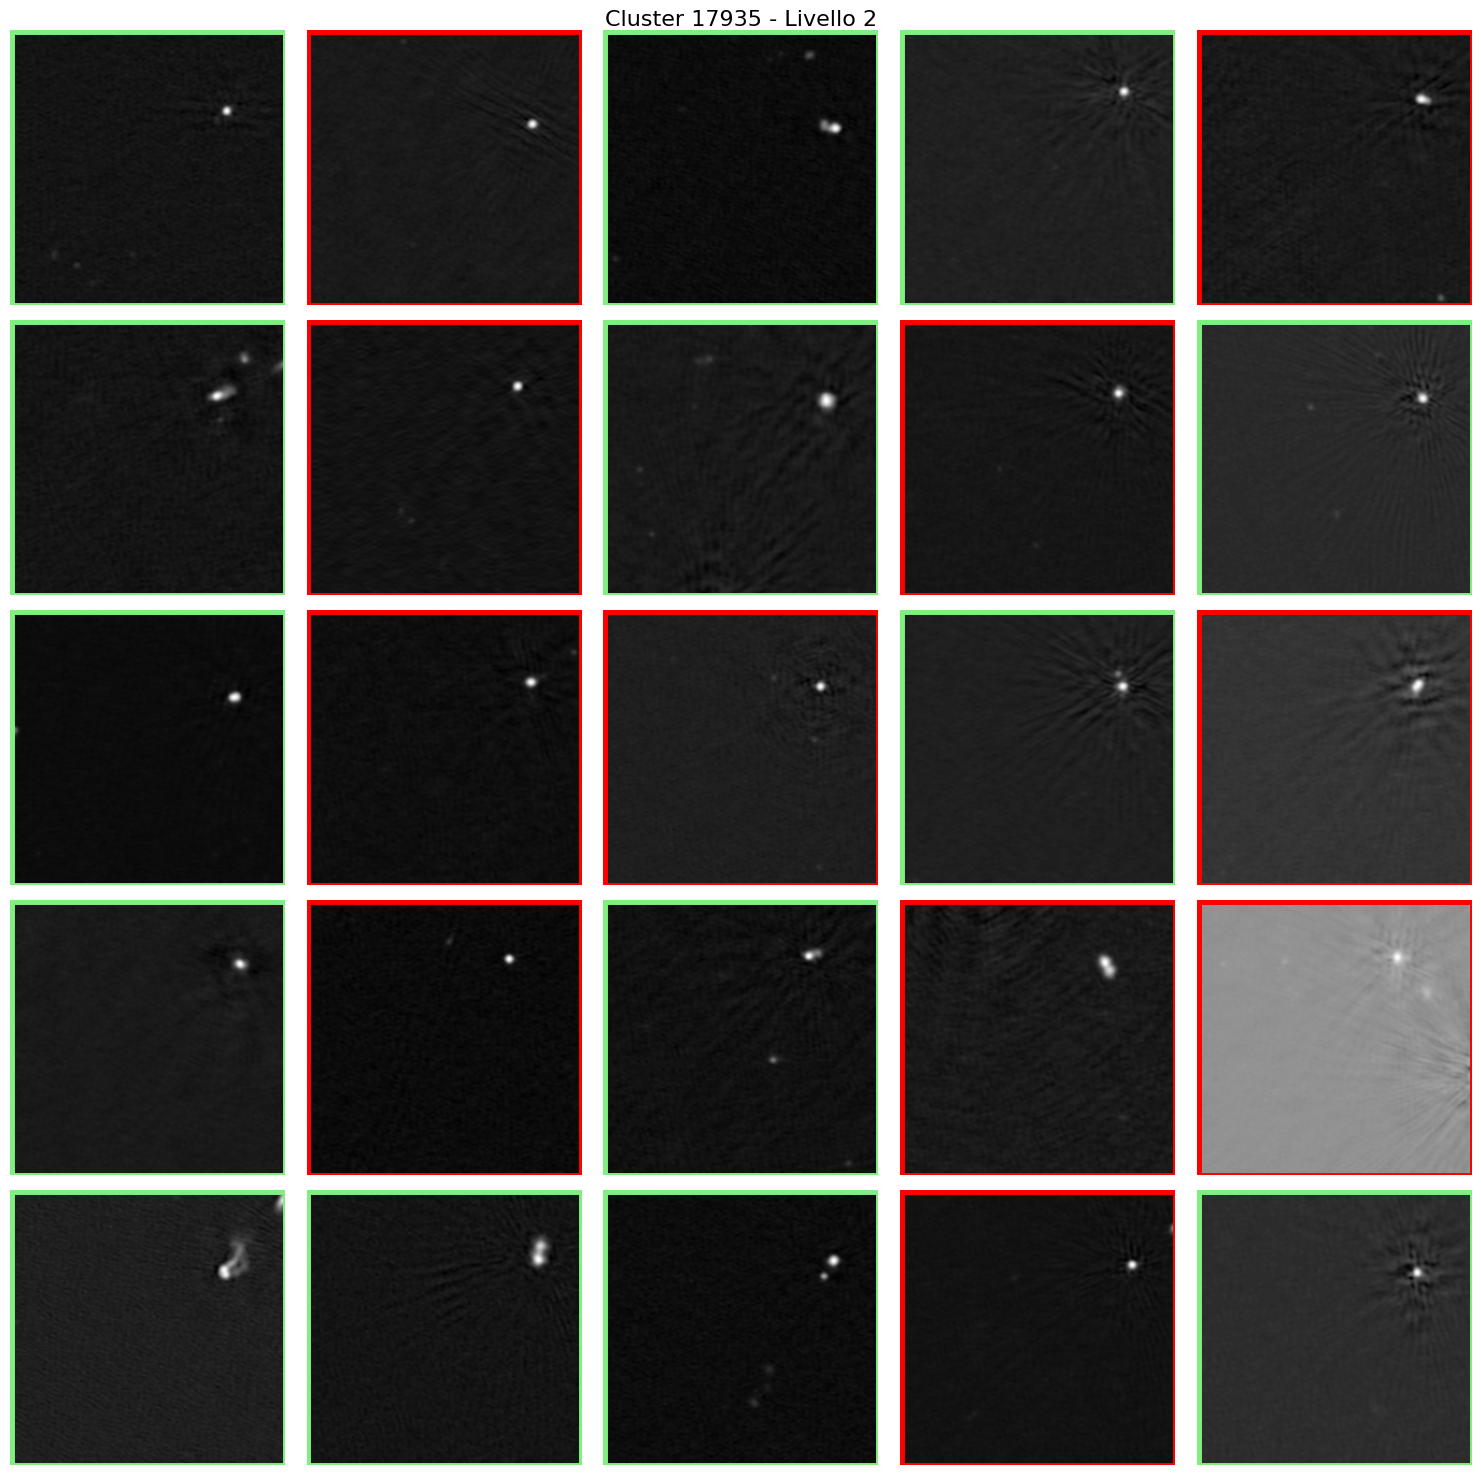

Plotting cluster 2697 at level 3 with 369455 images...


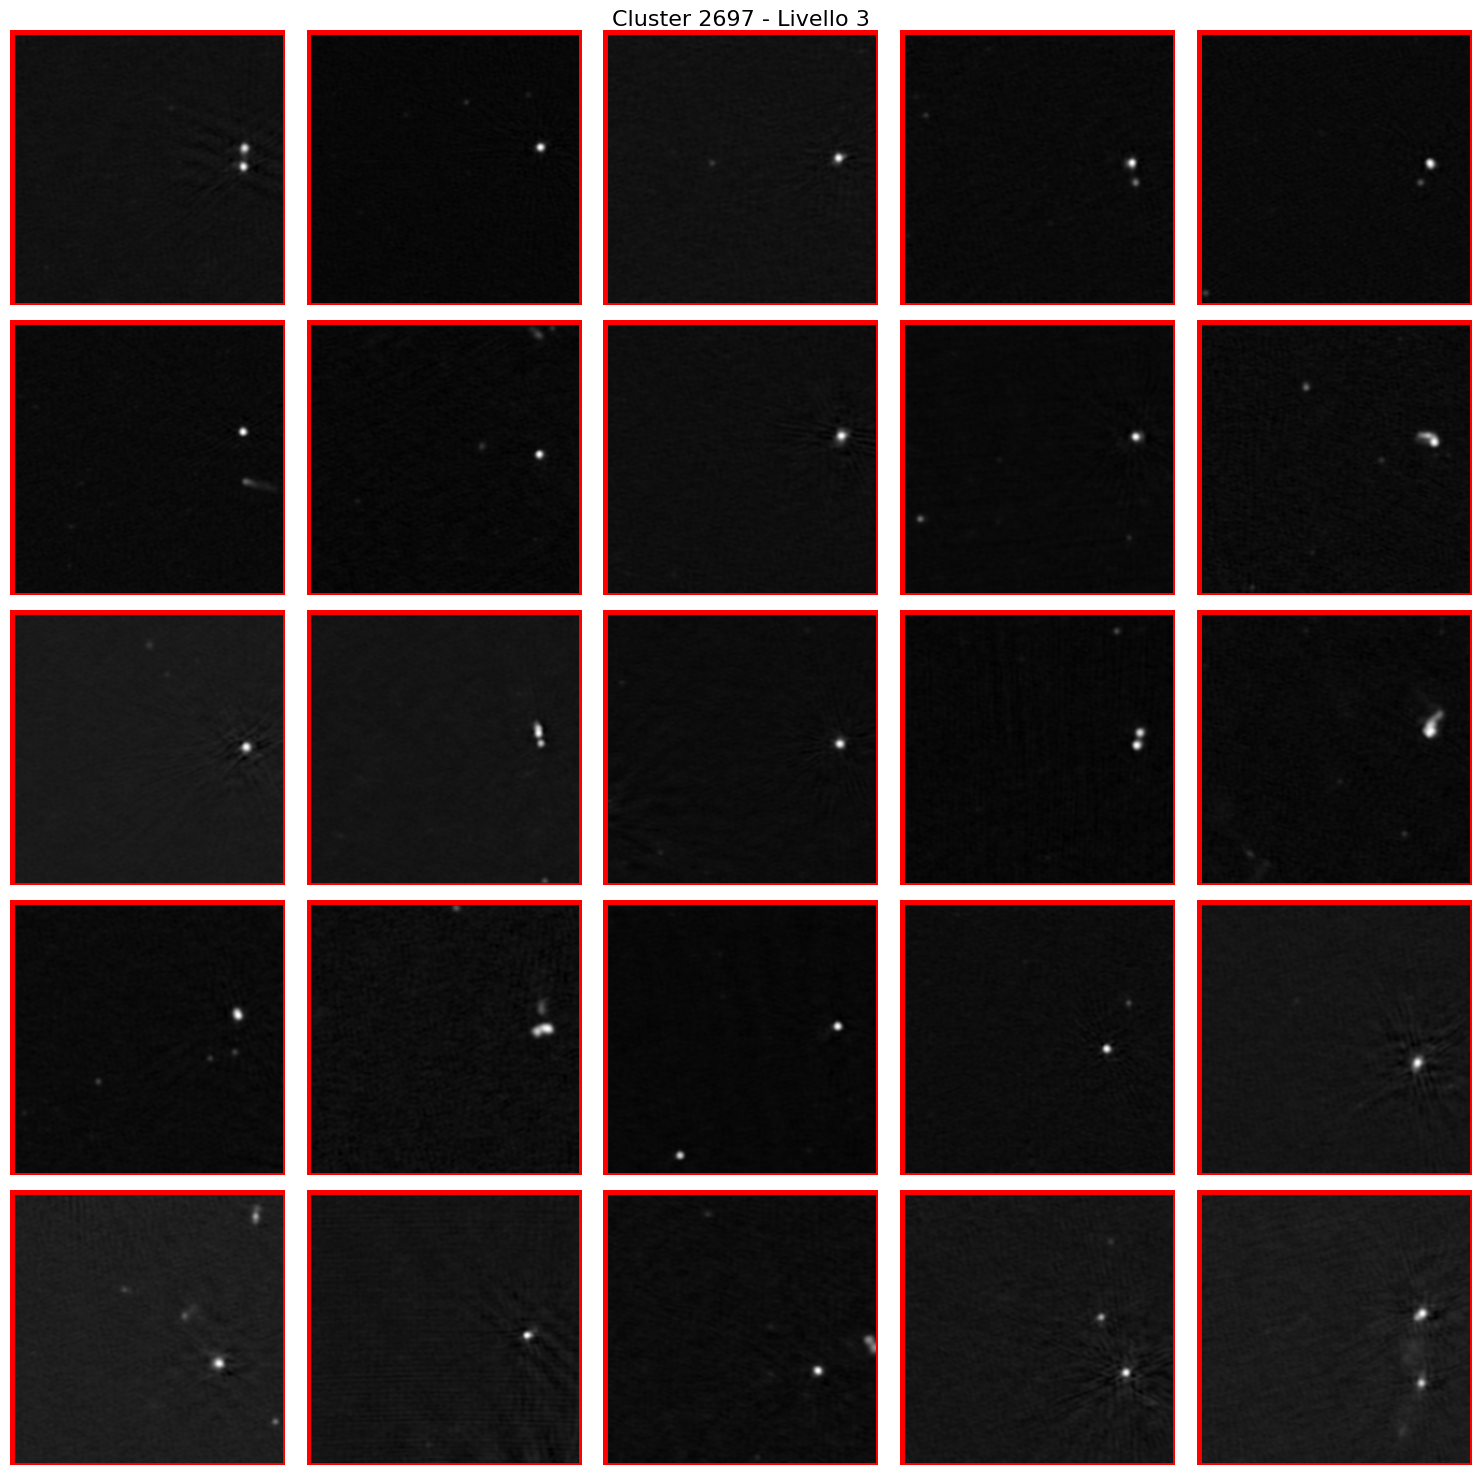

In [6]:
item = sampled_indices[189999]  # Elemento da tracciare
clusters_info = get_item_clusters(cl.flat_clusters, cl.clusters, item)

# Visualizza gli indici e gli elementi dei cluster
for level, (cluster_index, cluster_elements) in clusters_info.items():
    print(f"Livello {level}:")
    print(f"  Indice del cluster: {cluster_index}")
    print(f"  Elementi del cluster: {cluster_elements}")

# Indici con bordo verde
#sampled_indices = [sampled_indices[3], sampled_indices[2]]

# Visualizza i cluster
plot_clusters(info, clusters_info, sampled_indices)
